# Settings

In [1]:
EXP_NO = 19
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [2]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

# Library

In [3]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import hog
from skimage.color import rgb2hsv
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile
from folder import experiment_dir_of
from target import soring_date2target

In [4]:
pd.options.display.float_format = '{:.5f}'.format

# Prepare directory

In [5]:
output_dir = experiment_dir_of(EXP_NO)

In [6]:
output_dir

'..\\scripts\\..\\experiments\\exp019'

# Prepare logger

In [7]:
logger = getLogger(__name__)

In [8]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [9]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-20 09:46:22,789 - __main__ - INFO - Experiment no: 19
2021-07-20 09:46:22,789 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-20 09:46:22,789 - __main__ - INFO - SEED: 1
2021-07-20 09:46:22,789 - __main__ - INFO - REGRESSION: True


# Load csv files

In [10]:
SINCE = time.time()

In [11]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-20 09:46:22,826 - __main__ - DEBUG - Start loading csv files (0.021 seconds passed)
2021-07-20 09:46:22,850 - __main__ - DEBUG - Complete loading csv files (0.045 seconds passed)


In [12]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [13]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Feature engineering

## Extract HSV features

In [14]:
def extract_and_flatten(image_array: np.ndarray) -> np.ndarray:
    hsv_image = rgb2hsv(image_array)
    return hsv_image.flatten()

In [15]:
%%time
train_features = {object_id: hog(load_photofile(object_id)) for object_id in train['object_id']}

Wall time: 1min 39s


In [16]:
%%time
X_test = np.array([hog(load_photofile(object_id)) for object_id in test['object_id']])

Wall time: 2min 28s


# Cross validation

In [17]:
train.set_index('object_id', inplace=True)

In [18]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    X_train = np.array([train_features[object_id] for object_id in train_object_ids])
    y_train = train.loc[train_object_ids, TARGET].values
    X_valid = np.array([train_features[object_id] for object_id in valid_object_ids])
    y_valid = train.loc[valid_object_ids, TARGET].values
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## train estimator
    estimator = Pipeline(
        steps=[
            ('decomposer', PCA(n_components=0.95, random_state=SEED, whiten=True)),
            ('estimator', SVR(C=10.0))
        ]
    )
    estimator.fit(X_train, y_train)
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        pred_train = pd.DataFrame(data=estimator.predict(X_train), columns=['pred'])
        pred_valid = pd.DataFrame(data=estimator.predict(X_valid), columns=['pred'])
        pred_test = pd.DataFrame(data=estimator.predict(X_test), columns=['pred'])
    else:
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'wb') as f:
        pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, X_train, X_valid, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

2021-07-20 09:50:31,315 - __main__ - DEBUG - Start fold 1 (248.509 seconds passed)
2021-07-20 09:50:31,660 - __main__ - DEBUG - Start training model (248.854 seconds passed)
2021-07-20 09:53:50,137 - __main__ - DEBUG - Complete training (447.332 seconds passed)
2021-07-20 09:54:44,929 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp019\cv_fold1_training.csv (502.123 seconds passed)
2021-07-20 09:54:44,944 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp019\cv_fold1_validation.csv (502.139 seconds passed)
2021-07-20 09:54:44,960 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp019\cv_fold1_test.csv (502.155 seconds passed)
2021-07-20 09:54:49,472 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp019\cv_fold1_model.pkl (506.666 seconds passed)
2021-07-20 09:54:49,676 - __main__ - DEBUG - Complete fold 1 (506.870 seconds passed)
2021-07-20 09:54:49,676 - __main__ - DEBUG - Start fold 2 (506.870 seconds passed)


# Evaluation

In [19]:
rmse = partial(mean_squared_error, squared=False)

In [20]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [21]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [22]:
metrics = defaultdict(list)

## Training set

In [23]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-20 10:12:01,113 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-20 10:12:01,160 - __main__ - DEBUG - Loss: 0.09663367616102224
2021-07-20 10:12:01,176 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-20 10:12:01,192 - __main__ - DEBUG - Loss: 0.09662599117551113
2021-07-20 10:12:01,192 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-20 10:12:01,207 - __main__ - DEBUG - Loss: 0.09651018670109346
2021-07-20 10:12:01,207 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-20 10:12:01,239 - __main__ - DEBUG - Loss: 0.09621696676272248
2021-07-20 10:12:01,243 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-20 10:12:01,255 - __main__ - DEBUG - Loss: 0.0968793532617047


In [24]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,0.87990,1
00309fb1ef05416f9c1f,2.31999,3
003a1562e97f79ba96dc,2.32008,3
004890880e8e7431147b,1.61200,2
00718c32602425f504c1,2.31989,3
...,...,...
ffa3259fff8e6f3818a1,2.32000,3
ffd4d361756587883e48,0.87999,1
ffd794b7b311b7b7fd92,1.55721,2


In [25]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-20 10:12:01,333 - __main__ - INFO - Training loss: 0.4530610850377928


In [26]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-20 10:12:01,366 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp019\prediction_train.csv


## Validation set

In [27]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-20 10:12:01,381 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-20 10:12:01,397 - __main__ - DEBUG - Loss: 1.1168934456477668
2021-07-20 10:12:01,397 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-20 10:12:01,414 - __main__ - DEBUG - Loss: 1.1620216013696982
2021-07-20 10:12:01,414 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-20 10:12:01,428 - __main__ - DEBUG - Loss: 1.13965746784907
2021-07-20 10:12:01,428 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-20 10:12:01,428 - __main__ - DEBUG - Loss: 1.1067445172847783
2021-07-20 10:12:01,428 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-20 10:12:01,444 - __main__ - DEBUG - Loss: 1.1350147170034974


In [28]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.09411,1
00309fb1ef05416f9c1f,0.18303,3
003a1562e97f79ba96dc,0.30685,3
004890880e8e7431147b,0.30765,2
00718c32602425f504c1,0.29368,3
...,...,...
ffa3259fff8e6f3818a1,0.30419,3
ffd4d361756587883e48,0.11004,1
ffd794b7b311b7b7fd92,0.30634,2


In [29]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-20 10:12:01,491 - __main__ - INFO - Validatino loss: 1.831098279707029


In [30]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-20 10:12:01,522 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp019\prediction_valid.csv


In [31]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-20 10:12:01,538 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp019\metrics.json


# Prediction

In [32]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [33]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,0.70295
000bd5e82eb22f199f44,0.75252
0015f44de1854f617516,1.10058
00388a678879ba1efa27,0.86086
005e1e7c6496902d23f3,0.57262
...,...
ffbe65ad399b632dcbd0,2.29142
ffd7b2d646c0320c311a,0.73622
ffdb93ede17d4501e530,1.21251


In [34]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,0.70295
1,0.75252
2,1.10058
3,0.86086
4,0.57262
...,...
5914,2.29142
5915,0.73622
5916,1.21251
5917,1.40060


In [35]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [36]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-20 10:12:01,759 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp019\019_submission.csv


2021-07-20 10:12:01,932 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp019\prediction.png


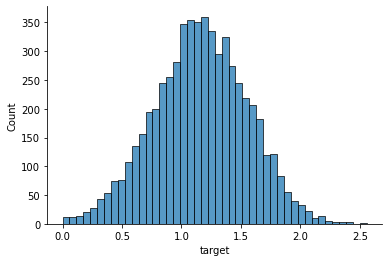

In [37]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [38]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-20 10:12:02,026 - __main__ - DEBUG - Complete (1539.221 seconds passed)
